In [4]:
#path
import os
from os.path import isdir, join
from pathlib import Path

# Scientific Math 
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go

#Deep learning
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

import random
import copy
import librosa
import IPython.display as ipd
# #Create an audio object.Audio controls being displayed in the frontend (only works in the notebook).

%matplotlib inline


In [3]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
train_audio_path = 'C:/Users/abhis/AI_codes/tensorflow-speech-recognition-challenge/train/audio/'

In [6]:
print(os.listdir(train_audio_path))

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


 # Checking a file defintion

In [7]:
file_path = '/yes/0a7c2a8d_nohash_0.wav'
wav1, sr = librosa.load(str(train_audio_path) + file_path, sr=None)
print(len(wav1),wav1.shape, wav1.max(), wav1.min())

16000 (16000,) 0.28720093 -0.19668579


# Visualization of Audio Signal

In [227]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
#'/on/0b56bcfe_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [228]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

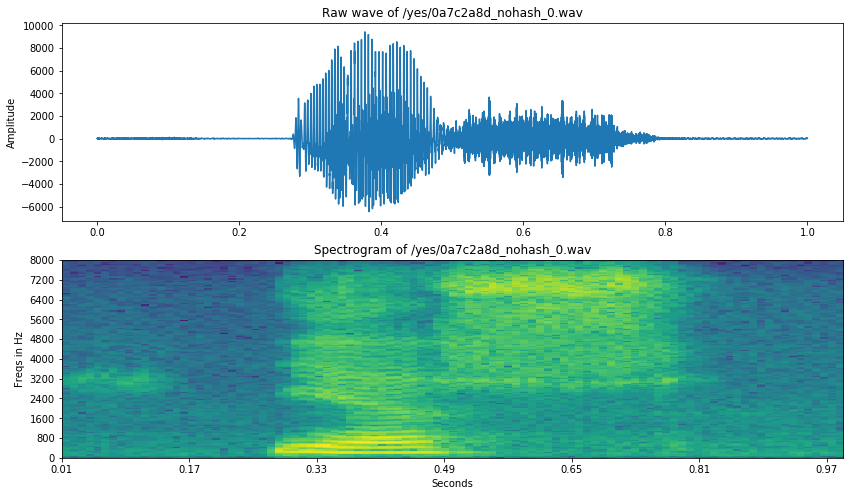

In [229]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [232]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

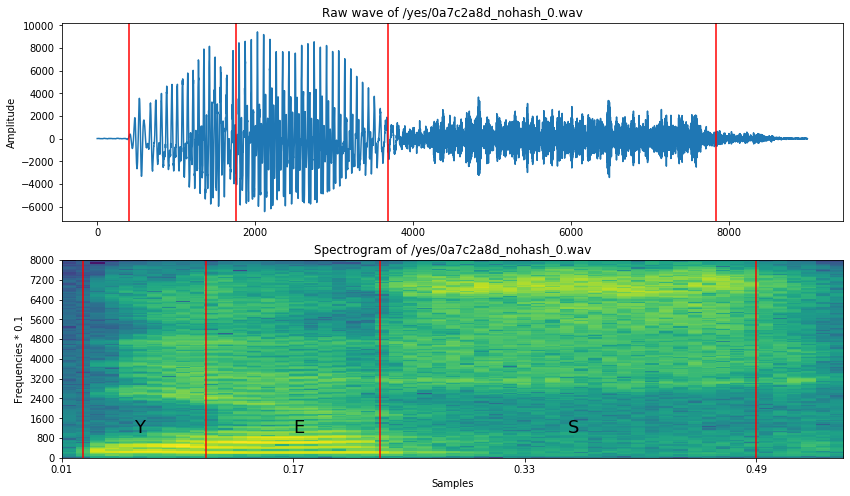

In [233]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

**Sampling rate **

Let us now look at the sampling rate of the audio signals

In [21]:
ipd.Audio(samples, rate=sample_rate)

In [237]:
#find count of each label and plot bar graph
labels=os.listdir(train_audio_path)
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

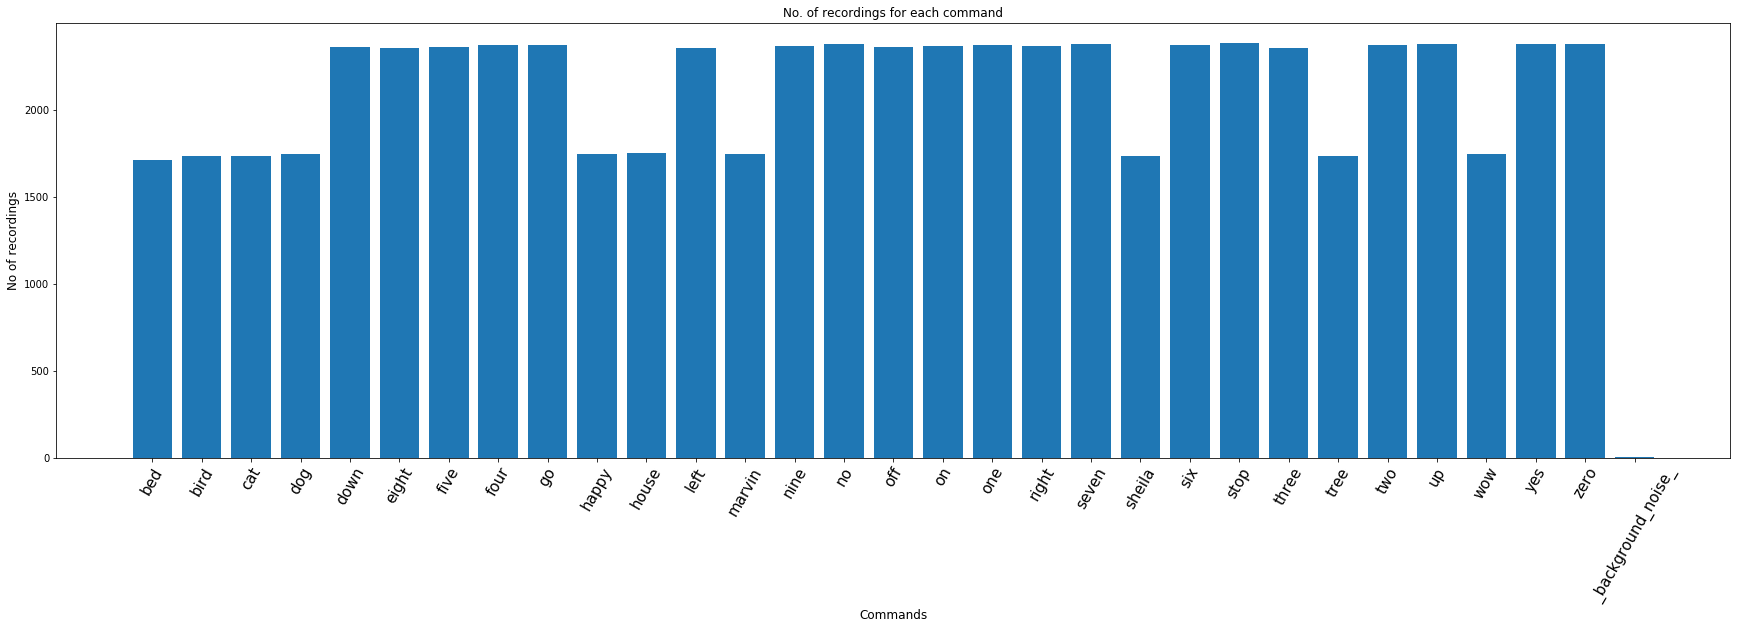

In [238]:
#plot
plt.figure(figsize=(30,8))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [240]:
sum(no_of_recordings)

64727

**Duration of recordings**

What’s next? A look at the distribution of the duration of recordings:

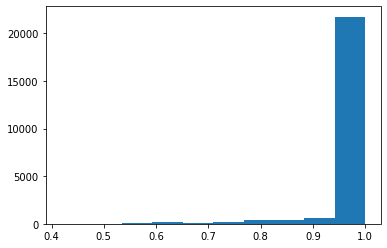

In [24]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings));

# Load Data & **Preprocessing the audio waves**

target list is ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] unknown list is other silence will be made from '_backgroundnoise'

Train data's sampling rate is 16000Hz, but for making lower computation cost, Resample to 8000hz

After training, test set also will resample to 8000Hz


* Resampling
* Removing shorter commands of less than 1 second

In [286]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs[1:])))
print(dirs)

Number of labels: 30
['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [287]:
all_wav = []    # all files samples 
unknown_wav = []
label_all = []   # All training labels
label_value = {}  # target lables with values
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknown_list = [d for d in dirs if d not in target_list and d != '_background_noise_' ]

print('target_list : ',end='')
print(target_list)
print('unknowns_list : ', end='')
print(unknown_list)
print('silence : _background_noise_')






target_list : ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknowns_list : ['bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero']
silence : _background_noise_


In [288]:
# resampling background noise 
background = [f for f in os.listdir(join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]
background_noise = []
for wav in background : 
    samples, sample_rate = librosa.load(join(join(train_audio_path,'_background_noise_'),wav))
    samples = librosa.resample(samples, sample_rate, 8000)
    background_noise.append(samples)

In [289]:
# Resampling all the training audio files to 8000 except background

i=0;
for direct in dirs[1:]:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    label_value[direct] = i
    i = i + 1
    print(str(i)+":" +str(direct) + " ", end="")
    for wav in waves:
        samples, sample_rate = librosa.load(join(join(train_audio_path,direct),wav), sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) != 8000 : 
            continue
            
        if direct in unknown_list:
            unknown_wav.append(samples)
        else:
            label_all.append(direct)
            all_wav.append([samples, direct])

1:bed 2:bird 3:cat 4:dog 5:down 6:eight 7:five 8:four 9:go 10:happy 11:house 12:left 13:marvin 14:nine 15:no 16:off 17:on 18:one 19:right 20:seven 21:sheila 22:six 23:stop 24:three 25:tree 26:two 27:up 28:wow 29:yes 30:zero 

In [290]:
# checking lenght of resample audio file
a = all_wav[0][0]
print('resample audio file:',len(a))
print('lenght of all_wav:',len(all_wav))

resample audio file: 8000
lenght of all_wav: 21312


split wav, label

In [291]:
# to delete the second column(labels), set obj=1, axis=1 ; separating samples & labels
wav_all = np.reshape(np.delete(all_wav,1,1),(len(all_wav)))  
label_all = [i for i in np.delete(all_wav,0,1).tolist()]

In [358]:
print(len(wav_all),len(label_all) , wav_all.shape)

21312 21312 (21312,)


In [293]:
len(unknown_wav)

36940

# Data Augmentation

For Data Augmentation. We will mix train wav, and same length(1 sec) noise(10%) from '_backgroundnoise'

In [294]:
#Random pick start point
def get_one_noise(noise_num = 0):
    selected_noise = background_noise[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000)
    return selected_noise[start_idx:(start_idx + 8000)]

In [295]:
max_ratio = 0.1
noised_wav = []
augment = 1
delete_index = []


for i in range(augment):
    new_wav = []
   
    noise = get_one_noise(i)
    
    # Mixing noise to all the audio files and saving in noised_wav list
    for i, s in enumerate(wav_all):
        if len(s) != 8000:
            delete_index.append(i)
            continue
        s = s + (max_ratio * noise)
        noised_wav.append(s)
        


In [296]:
np.delete(wav_all, delete_index)
np.delete(label_all, delete_index)

array(['down', 'down', 'down', ..., 'yes', 'yes', 'yes'], dtype='<U5')

In [297]:
wav_vals = np.array([x for x in wav_all])
label_vals = [x for x in label_all]
wav_vals.shape

(21312, 8000)

In [298]:
labels = copy.deepcopy(label_vals)
for _ in range(augment):
    label_vals = np.concatenate((label_vals, labels), axis = 0)
label_vals = label_vals.reshape(-1,1)

In [299]:
len(label_vals)

42624

Random sampling from unknown wav data

In [300]:
#knowns audio random sampling
unknown = unknown_wav
np.random.shuffle(unknown_wav)
unknown = np.array(unknown)
unknown = unknown[:2000*(augment+1)]
unknown_label = np.array(['unknown' for _ in range(2000*(augment+1))])
unknown_label = unknown_label.reshape(2000*(augment+1),1)

In [301]:
delete_index = []
for i,w in enumerate(unknown):
    if len(w) != 8000:
        delete_index.append(i)
unknown = np.delete(unknown, delete_index, axis=0)

Random sampling from '_backgroundnoise'

Random pick background noise

In [302]:
#silence audio
silence_wav = []
num_wav = (2000*(augment+1))//len(background_noise)
for i, _ in enumerate(background_noise):
    for _ in range((2000*(augment+1))//len(background_noise)):
        silence_wav.append(get_one_noise(i))
silence_wav = np.array(silence_wav)
silence_label = np.array(['silence' for _ in range(num_wav*len(background_noise))])
silence_label = silence_label.reshape(-1,1)
silence_wav.shape

(3996, 8000)

In [303]:
wav_vals    = np.reshape(wav_vals,    (-1, 8000))
noised_wav  = np.reshape(noised_wav,  (-1, 8000))
unknown       = np.reshape(unknown,   (-1, 8000))
silence_wav = np.reshape(silence_wav, (-1, 8000))

Check Dimensions

In [304]:
print(wav_vals.shape)
print(noised_wav.shape)
print(unknown.shape)
print(silence_wav.shape)

(21312, 8000)
(21312, 8000)
(4000, 8000)
(3996, 8000)


In [305]:
print(label_vals.shape)
print(unknown_label.shape)
print(silence_label.shape)

(42624, 1)
(4000, 1)
(3996, 1)


Concatenate wavs, labels

In [306]:
wav_vals = np.concatenate((wav_vals, noised_wav), axis = 0)
wav_vals = np.concatenate((wav_vals, unknown), axis = 0)
wav_vals = np.concatenate((wav_vals, silence_wav), axis = 0)

In [307]:
label_vals = np.concatenate((label_vals, unknown_label), axis = 0)
label_vals = np.concatenate((label_vals, silence_label), axis = 0)

In [338]:
print(len(wav_vals))
print(len(label_vals))
wav_vals.shape

50620
50620


(50620, 8000)

In [309]:
label_vals.shape

(50620, 1)

# Prepare for Training 

In [311]:
train_wav, test_wav, train_label, test_label = train_test_split(wav_vals, label_vals, 
                                                                    test_size=0.2,
                                                                    random_state = 2000,
                                                                   shuffle=True)

In [312]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 600
drop_out_rate = 0.3
input_shape = (8000,1)

In [313]:
#For Conv1D add Channel
train_wav = train_wav.reshape(-1,8000,1)
test_wav = test_wav.reshape(-1,8000,1)

In [345]:
print('train data:' , train_wav.shape) # Shape of train in 3 d
print('test data:', test_wav.shape) # # Shape of test data  in 3 d

train data: (40496, 8000, 1)
test data: (10124, 8000, 1)


In [314]:
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

In [315]:
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [316]:
#Make Label data 'string' -> 'class num'
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

#Make Label data 'class num' -> 'One hot vector'
train_label = keras.utils.to_categorical(train_label, len(label_value))
test_label = keras.utils.to_categorical(test_label, len(label_value))

In [317]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))

Train_Wav Demension : (40496, 8000, 1)


In [318]:
print('Train_Label Demension : ' + str(np.shape(train_label)))

Train_Label Demension : (40496, 12)


In [319]:
print('Test_Wav Demension : ' + str(np.shape(test_wav)))

Test_Wav Demension : (10124, 8000, 1)


In [320]:
print('Test_Label Demension : ' + str(np.shape(test_label)))

Test_Label Demension : (10124, 12)


In [321]:
print('Number Of Labels : ' + str(len(label_value)))

Number Of Labels : 12


In [322]:
label_list = list(label_value.keys())
#val_list = list(label_value.values()) 
#label_list
#print(label_list[3]) 

In [323]:
#Conv1D Model
input_tensor = Input(shape=(input_shape))

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)  
# Max pooling -remove variability in the time-frequency space that exists due
#to speaking styles, channel distortions,
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(len(label_value), activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])

In [324]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 3995, 8)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 3995, 8)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1994, 16)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1994, 16)          0   

Train !!

In [325]:
history = model.fit(train_wav, train_label, validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=100,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/100
40496/40496 [==============================] - 320s 8ms/sample - loss: 2.2967 - accuracy: 0.1850 - val_loss: 2.1147 - val_accuracy: 0.2843
Epoch 2/100
40496/40496 [==============================] - 339s 8ms/sample - loss: 1.9180 - accuracy: 0.3174 - val_loss: 1.7745 - val_accuracy: 0.3867
Epoch 3/100
40496/40496 [==============================] - 339s 8ms/sample - loss: 1.6721 - accuracy: 0.4047 - val_loss: 1.6249 - val_accuracy: 0.4558
Epoch 4/100
40496/40496 [==============================] - 338s 8ms/sample - loss: 1.4596 - accuracy: 0.4883 - val_loss: 1.3950 - val_accuracy: 0.5259
Epoch 5/100
40496/40496 [==============================] - 338s 8ms/sample - loss: 1.2947 - accuracy: 0.5512 - val_loss: 1.1667 - val_accuracy: 0.6166
Epoch 6/100
40496/40496 [==============================] - 338s 8ms/sample - loss: 1.1355 - accuracy: 0.6070 - val_loss: 1.1826 - val_accuracy: 0.6096
Epoch 7/100
40496/40496 [===================

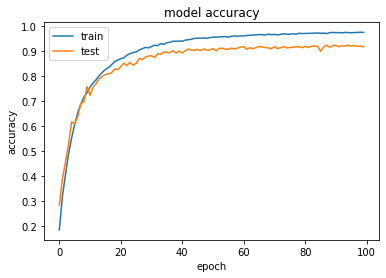

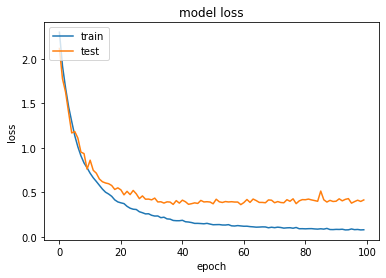

In [326]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [327]:
model.save_weights(r'C:\Users\abhis\AI_codes\tensorflow-speech-recognition-challenge\Model_Checkpoints\SpeechModel_checkpoint_may3')

In [328]:
model.save(r'C:\Users\abhis\AI_codes\tensorflow-speech-recognition-challenge\Save_Model\my_model_may3')

INFO:tensorflow:Assets written to: C:\Users\abhis\AI_codes\tensorflow-speech-recognition-challenge\Save_Model\my_model_may3\assets


Prediction 

In [200]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    
    return label_list[index]

In [234]:
import IPython.display as ipd
import random
index=random.randint(0,len(test_wav)-1)
print(index)
samples=test_wav[index].ravel()
print("Audio:",label_list[np.argmax(test_label[index])])
ipd.Audio(samples, rate=8000)

9639
Audio: right


In [235]:
print("Text:",predict(samples))

Text: right


In [329]:
## Evaluate
score = model.evaluate(test_wav, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4152138417771403
Test accuracy: 0.9157448


In [330]:
y_pred = model.predict(test_wav)
y_pred_class = np.argmax(y_pred, axis=1)
print(y_pred_class)


[10  3  6 ...  5  3  7]


In [331]:
y_true_classes=np.argmax(test_label, axis=1)
print(y_true_classes)

[10  3  6 ...  5  3  7]


In [332]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print('Confusion Matrix')
print(confusion_matrix(y_true_classes, y_pred_class))

print('Classification Report')
print(classification_report(y_true_classes, y_pred_class))

Confusion Matrix
[[780  12   0   0   7   3   0   1   0   2  10   1]
 [  8 800   0   6   2   3   3   3   2  18  10   1]
 [  1   0 785   1   2  10   4  30  13   1   5   1]
 [  2   3   0 810   0   2   7   7   2  10  11   0]
 [ 31   2  10   0 759   9   0  11   7   2   6   1]
 [  0   2   4   0   3 777   5   3   1   2  20   1]
 [  0   2   0   2   0  11 804  22   0   0  10   0]
 [  1   3  10   0   8  10  19 832   6   1   6   0]
 [  2   0   8   3   1   2   1  12 831   4   4   1]
 [  8   9   0  17   3   4   5  10   8 768   7   1]
 [ 29  27  12  20   8  25  46  39  21  28 562   2]
 [  1   0   5   0   1  18   8  10   1   0   7 763]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       816
           1       0.93      0.93      0.93       856
           2       0.94      0.92      0.93       853
           3       0.94      0.95      0.95       854
           4       0.96      0.91      0.93       838
           5       0.89

Each column represents a set of samples that were predicted to be each label, so the first column represents all the clips that were predicted to be "yes", the second all those that were predicted to be "no" words, the third "up", and so on.

Each row represents clips by their correct, ground truth labels. The first row is all the clips that were "yes", the second clips that were "no" words, the third "up", etc.

In [215]:
label_value

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

# Checking with "Test" Folder clips 

In [443]:
test_audio_path = 'C:/Users/abhis/AI_codes/tensorflow-speech-recognition-challenge/test/val_audio/clip_000c41da7.wav'
#clip_0000adecb.wav'

In [444]:
samples, sample_rate = librosa.load(test_audio_path, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)


In [445]:
import IPython.display as ipd
import random
#index=random.randint(0,len(test_wav)-1)
#print(index)
#samples=test_wav[index].ravel()
#print("Audio:",label_list[np.argmax(test_label[index])])
ipd.Audio(samples, rate=8000)

In [446]:
print("Text:",predict(samples))

Text: on


In [436]:
# copied manually 100 files from Test/audio folder to Test/val_audio 
test_val_audio_path = 'C:/Users/abhis/AI_codes/tensorflow-speech-recognition-challenge/test/val_audio'
test_waves = [f for f in os.listdir(test_val_audio_path) if f.endswith('.wav')]
b = []
for x in test_waves:
    temp = []
    samples, sample_rate = librosa.load(join(test_val_audio_path,x), sr = 16000)
    samples = librosa.resample(samples, sample_rate, 8000)
    a = predict(samples)
    temp.append(str(x))
    temp.append(str(a))
    b.append(temp)
    
 
    

In [447]:
import pandas as pd
df = pd.DataFrame(b, columns = ['FileName','Label'])
df

,FileName,Label
0,clip_0000adecb.wav,unknown
1,clip_0000d4322.wav,go
2,clip_0000fb6fe.wav,up
3,clip_000a96d0a.wav,unknown
4,clip_000b01093.wav,unknown
5,clip_000b378f1.wav,unknown
6,clip_000b9514b.wav,unknown
7,clip_000c07b07.wav,unknown
8,clip_000c2c07b.wav,go
9,clip_000c41da7.wav,on
